In [9]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

In [10]:
function uni_dyna(x,u)
    return [x[1]+dt*u[1]*cos(x[3]), x[2]+dt*u[1]*sin(x[3]), x[3]+dt*u[2]]
end

function circleShape(h, k, r); gr()
    theta = LinRange(0, 2*pi, 500)
    h.+ r*sin.(theta), k.+ r*cos.(theta)
end

N = 100
n_x = 3
n_u = 2
state_dimension = 3
control_dimension = 2
horizon = N
tf = 10.
dt = tf/(N)
u1_b = 0.15
u2_b = 0.75

xo = @SVector [10.0,0.0]
ro = 4.0
ra = 3.0

# Q = 50.0*Diagonal(@SVector ones(6))
# Qf = 10000.0*Diagonal(@SVector ones(6))
# R = 1.0e0*Diagonal(@SVector ones(4))

Q = Diagonal(@SVector [50, 10, 5])*0.6 # This is reference tracking and control cost
Qf = Diagonal(@SVector [50, 10, 5])*50
R = Diagonal(@SVector [10, 5])*0.8

noise_level = 0.5

full_traj = []

num_sim = 1000

for sim in 1:num_sim

    x0 = [0,0,0] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]
    xf = [20,0.0,0] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    # xf2 = @SVector [20,-2,0,0,-2,pi]

    X_ref = hcat(collect(LinRange(x0[1],xf[1],N+1)), 
            collect(LinRange(x0[2],xf[2],N+1)),
            collect(LinRange(x0[3],xf[3],N+1)),
            )

    problem_size = N*(n_x+n_u)

    model = Model(Ipopt.Optimizer)

    @variable(model, x11[1:N+1])
    @variable(model, x12[1:N+1])
    @variable(model, x13[1:N+1])

    @variable(model, 0<=u11[1:N+1] , start = 0)
    @variable(model, u12[1:N+1], start = 0);

    fix(x11[1],x0[1],force=true)
    fix(x12[1],x0[2],force=true)
    fix(x13[1],x0[3],force=true)

    fix(u11[N+1],0.0,force=true)
    fix(u12[N+1],0.0,force=true)

    X_full = vcat(x11',x12',x13')
    U_full = vcat(u11',u12')

    @objective(model, Min, tr((X_full'[1:N,:] - X_ref[1:N,:])*Q*(X_full[:,1:N] - X_ref'[:,1:N])) + tr(U_full'*R*U_full) + (X_full'[1+N,:] - X_ref[1+N,:])'*Qf*(X_full[:,1+N] - X_ref'[:,1+N]))

    @constraint(model, [t in 1:N], uni_dyna([x11[t],x12[t],x13[t]],[u11[t],u12[t]]) == [x11[t+1],x12[t+1],x13[t+1]]);
    @constraint(model, [t in 1:N+1], (xo[1] - x11[t])^2 + (xo[2] - x12[t])^2 - ro^2 >= 0);

    for i in 1:N+1
        set_start_value(x11[i],X_ref[i,1]+ 0.1*(2*rand()-1))
        set_start_value(x12[i],X_ref[i,2]+ 0.1*(2*rand()-1))
        set_start_value(x13[i],X_ref[i,3]+ 0.1*(2*rand()-1))

    end
    
    optimize!(model)

    @assert is_solved_and_feasible(model)

    X1 = hcat(value.(x11),value.(x12),value.(x13))

    traj = hcat(value.(u11),value.(u12),
                value.(x11),value.(x12),value.(x13), 
                )

    if sim == 1
        full_traj = traj[1:100,:]
        Plots.plot(circleShape(xo[1], xo[2], ro), seriestype = [:shape, ], lw=0.5, c = :gray, linecolor = :white, legend = false, fillalpha = 0.2, aspect_ratio = 1)
        Plots.plot!(X1[:,1],X1[:,2],color="blue",label="Agent 1")
        # Plots.plot!(X2[:,1],X2[:,2],color="orange",label="Agent 2")
    else
        full_traj = vcat(full_traj,traj[1:100,:])
        Plots.plot!(X1[:,1],X1[:,2],color = "blue",label="")
        # Plots.plot!(X2[:,1],X2[:,2],color="orange",label="")
    end
end

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     1095
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1296

Total number of variables............................:      500
                     variables with only lower bounds:      100
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8665320e+01 1.60e+01 2.76e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

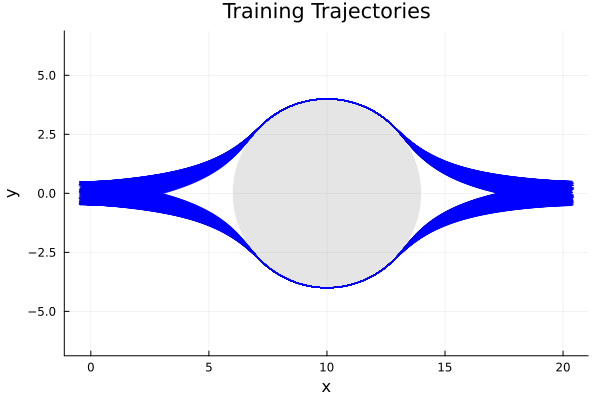

In [11]:
Plots.xlabel!("x")
Plots.ylabel!("y")
Plots.title!("Training Trajectories")

In [12]:
for i in 1:(size(full_traj)[2])
    println(maximum(full_traj[:,i]))
end

2.7383636780091254
0.6836231109752537
20.242869184489024
3.999999890047768
0.8979626762533519


In [13]:
CSV.write("data/single_uni_full_traj.csv",  Tables.table(full_traj), writeheader=false)

"data/single_uni_full_traj.csv"

In [27]:
full_traj

10000×5 Matrix{Float64}:
 1.9927   0.342931    0.0       0.0           0.0
 2.00082  0.261174    0.19927   8.22853e-36   0.0342931
 2.00539  0.201956    0.399234  0.00686009    0.0604105
 2.00808  0.159868    0.599407  0.0189674     0.0806061
 2.00983  0.130786    0.799564  0.0351362     0.0965928
 2.01115  0.111595    0.99961   0.0545196     0.109671
 2.01229  0.0999582   1.19952   0.0765319     0.120831
 2.01342  0.0941277   1.39928   0.100788      0.130827
 2.01462  0.0928057   1.5989    0.127053      0.14024
 2.01594  0.0950332   1.79838   0.155214      0.14952
 ⋮                                           
 1.98834  0.0819755  18.1915    0.198127     -0.128976
 1.9824   0.0794355  18.3887    0.172553     -0.120779
 1.97553  0.0795554  18.5855    0.148668     -0.112835
 1.9675   0.0829923  18.7818    0.126425     -0.10488
 1.958    0.0906169  18.9774    0.105827     -0.0965803
 1.94667  0.103566   19.1723    0.0869464    -0.0875186
 1.93302  0.123304   19.3662    0.0699312    -0.077